# Data Pre Processing

In [1]:
### Comment Section

#Data Description details link: https://competitions.codalab.org/competitions/11161#learn_the_details-data2

#productCategoryID (serial) productID categoryID
#productID (serial) priceLog2 (log-transformed product price) product.name.tokens (comma separated hashed product name tokens) imageName (name of the corresponding product image)

#train-purchases.csv 
#sessionId (serial) timeframe (time since the first query in a session, in milliseconds) eventdate (calendar date) ordernumber (serial product orderID; groups all products purchased together ~ shopping cart; if a user bought several products, there are several records sharing the same ordernumber) itemId (purchased product)

#train-item-views
#sessionId userId itemId timeframe (time since the first query in a session, in milliseconds) eventdate (calendar date)

#train_data
#queryId (serial) sessionId (serial) userId (serial) timeframe (time since the first query in a session, in milliseconds) duration (page dwell time, in milliseconds) eventdate (calendar date) searchstring.tokens (comma separated hashed query tokens; empty if it is a query-less case) categoryId (product category ID; empty if it is a query-full session) items (productIDs returned by the default ranking algorithm on the SERP; this IDs must be re-ranked).

In [ ]:
### possible features
# UserId-> Range of Cost
# Item rating? ->Based on purchases. Assumption more purchases, better rating
# Ranking of items -> on a scale of 1-0. Shouldn't it be based on queryId, SessionId and then items?

In [52]:
import os
import pandas as pd
import time
import numpy as np
from matplotlib import pyplot as plt

In [3]:
start = time. time()
#parent_path_to_data
path_to_data= "D:\Courses\InfoStorage\Project\Data\Data-20190409T171847Z-001\Data"
#TO DO: Code refractor get os.cwd() and choose relative path.

product_categories= pd.read_csv(path_to_data+"\product-categories.csv",delimiter=";")

products= pd.read_csv(path_to_data+"\products.csv",delimiter=";")
#Last Value in the list is actually the imageName
products['imageName'] = products['product.name.tokens'].apply(lambda x: x.split(',')[-1])
#Take out the last value as it is not a product name token
products['product.name.tokens']=products['product.name.tokens'].apply(lambda x: x.split(',')[:-1])

train_purchases= pd.read_csv(path_to_data+"\\train-purchases.csv",delimiter=";")
#This data is against the format given there is a User ID with value NaN
train_item_views= pd.read_csv(path_to_data+"\\train-item-views.csv",delimiter=";")
#Some User Ids have a Value NaN

train_clicks= pd.read_csv(path_to_data+"\\train-clicks.csv",delimiter=";")
#QueryId TimeFrame ItemId

combined_data= pd.read_csv(path_to_data+"\\train-queries.csv",delimiter=";")
end = time. time()
print("Data read took: %f seconds " % (end-start))

Data read took: 31.438726 seconds 


D:\Courses\InfoStorage\Anaconda\envs\cs670\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
#Convert the date to the date format
combined_data['eventdate'] = pd.to_datetime(combined_data["eventdate"])

#We focus only on query-full queries
combined_data = combined_data[~combined_data["searchstring.tokens"].isnull()]

In [25]:
combined_data.head()

,queryId,sessionId,userId,timeframe,duration,eventdate,searchstring.tokens,categoryId,items,is.test
0,1,1,NaN,16327074,311,2016-05-09,"16655,244087,51531,529597,58153",0,"7518,71,30311,7837,30792,8252,81766,9338,62220...",False
1,2,2,NaN,705527,314,2016-05-09,"528941,529116",0,"70095,15964,8627,134850,32754,100747,74771,314...",False
2,3,3,NaN,0,502,2016-05-09,"133713,16655,138389",0,"59081,51125,9338,9550,32087,62793,2717,10403,3...",True
3,4,4,NaN,0,1092,2016-05-09,"3918,3822,460416,528812,5276,529517,528738",0,"46632,57465,79064,57748,6080,35997,47088,6078,...",False
4,5,5,NaN,102700,266,2016-05-09,"529223,199482",0,"27312,84626,12621,46209,5140,57539,5368,12923,...",False


In [37]:
# Split QueryId-> item1,item2,item3 into 1:1 mapping 
# These are items that appeared after the query result
query_item = []
for session,query,items,userId in combined_data[["sessionId","queryId", "items","userId"]].values:
    items = map(np.int64,items.split(','))
    for i in items:
        query_item.append( (session,query,i,userId) )
query_item = pd.DataFrame().from_records(query_item, columns=["sessionId","queryId","itemId","userId"])

In [16]:
train_item_views.head()

,sessionId,userId,itemId,timeframe,eventdate
0,1,NaN,81766,526309,2016-05-09
1,1,NaN,31331,1031018,2016-05-09
2,1,NaN,32118,243569,2016-05-09
3,1,NaN,9654,75848,2016-05-09
4,1,NaN,32627,1112408,2016-05-09


In [17]:
train_item_views['eventdate'] = pd.to_datetime(train_item_views["eventdate"])
train_item_views.sort_values(["sessionId", "userId", "eventdate", "timeframe", "itemId"], inplace=True)
train_item_views= train_item_views.reset_index(drop=True)

In [18]:
train_item_views.head()

,sessionId,userId,itemId,timeframe,eventdate
0,1,NaN,9654,75848,2016-05-09
1,1,NaN,33043,173912,2016-05-09
2,1,NaN,32118,243569,2016-05-09
3,1,NaN,12352,329870,2016-05-09
4,1,NaN,35077,390072,2016-05-09


In [19]:
train_clicks.sort_values(["queryId", "timeframe", "itemId"], inplace=True)
train_clicks= train_clicks.reset_index(drop=True)

In [20]:
train_clicks.head() #what is time frame wrt to this?

,queryId,timeframe,itemId
0,1,16338861,24857
1,2,721764,36246
2,4,20684,13931
3,5,118873,35472
4,6,52095,73191


In [21]:
train_purchases.head() # timeframe - time since the first query in a session, in milliseconds

,sessionId,userId,timeframe,eventdate,ordernumber,itemId
0,150,18278.0,17100868,2016-05-06,16421,25911
1,151,NaN,6454547,2016-05-06,16290,175874
2,156,7.0,1721689387,2016-05-27,21173,35324
3,179,NaN,343001,2016-05-09,16924,31233
4,246,34.0,2311046,2016-05-09,16936,34677


In [22]:
train_purchases.sort_values(["sessionId", "userId", "eventdate", "timeframe", "itemId", "ordernumber"], inplace=True)
train_purchases= train_purchases.reset_index(drop=True)

In [23]:
Train_data= combined_data.loc[combined_data['is.test']==False]
Test_data= combined_data.loc[combined_data['is.test']==True]

In [ ]:
#Some stats
#Number of Unique Sessions in the Test_+Train = 40345
#Number of Unique Sessions in the Test+Train(after removing NaN) = 18356
#Number of Unique Users in the Train+Test= 18113

In [43]:
print("Number of Unique Sessions in the Test+Train=",len(query_item['sessionId'].unique()))

Number of Unique Sessions in the Test+Train= 40345


In [49]:
temp=combined_data
temp = temp[np.isfinite(temp['userId'])] #Drop all rows who's UserID is NAN
print("Number of Unique Users in the Train+Test=", len(temp['userId'].unique()))
L=[]
for region,df_region in temp.groupby('sessionId'):
    L.append(len(df_region['queryId']))

Number of Unique Users in the Train+Test= 18113


In [54]:
print("Number of Unique Sessions in the Test+Train=",len(temp['sessionId'].unique()))

Number of Unique Sessions in the Test+Train= 18356


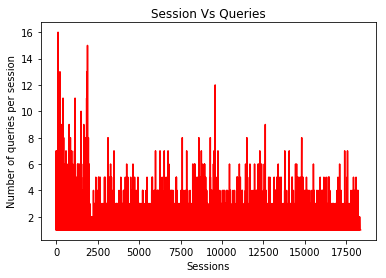

In [53]:
plt.plot(L,'r')
plt.xlabel("Sessions")
plt.ylabel("Number of queries per session")
plt.title("Session Vs Queries")
plt.show()